<a href="https://colab.research.google.com/github/thurvans/wa/blob/main/Netflix_Cookie_Checker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Use Netflix-cookie-checker

---



In this Colab notebook, we will see how to set up and run Netflix-cookie-checker on Linux in order to validate cookies.

## Join [Discord Server](https://discord.gg/RSCdKeKB5X) for support!

---



## a) Upload cookies
# 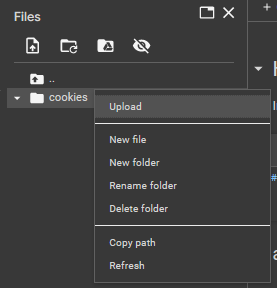

### Upload your cookies to the cookies folder



# b) Install requirements

In [1]:
# Install the required packages
!pip install Requests
!pip install bs4
!pip install beautifulsoup4
!pip install psutil
!pip install aiohttp
!pip install lxml
!pip install colorama

# c) Convert Netscape cookies to json format

In [4]:
import json
import os
import shutil
import sys
from colorama import Fore


def identify_file(file_name):
    try:
        with open(file_name, "r") as file_content:
            # Try to parse the file as JSON
            json.load(file_content)
            return "json"
    except json.JSONDecodeError:
        # If it fails to parse as JSON, assume it's a Netscape file
        return "netscape"
    except Exception as e:
        # If any other error occurred, print it
        print(f"An error occurred while processing {file_name}: {str(e)}")
        return "error"


def convert_netscape_cookie_to_json(cookie_file_content):
    cookies = []
    for line in cookie_file_content.splitlines():
        fields = line.strip().split("\t")
        if len(fields) >= 7:
            cookie = {
                "domain": fields[0].replace("www", ""),
                "flag": fields[1],
                "path": fields[2],
                "secure": fields[3] == "TRUE",
                "expiration": fields[4],
                "name": fields[5],
                "value": fields[6],
            }
            cookies.append(cookie)

    json_content = json.dumps(cookies, indent=4)
    return json_content


no_of_cookies = 0

try:
    if os.name == "posix":
        folder_path = "cookies"
    else:
        while True:
            import tkinter
            from tkinter import filedialog

            print(
                Fore.YELLOW
                + "\n<<< Select Netscape cookies folder >>>\n\n"
                + Fore.RESET
            )
            tkinter.Tk().withdraw()
            folder_path = filedialog.askdirectory()
            if folder_path == "":
                if os.path.isdir("cookies"):
                    folder_path = "cookies"
                    print(
                        Fore.YELLOW
                        + "Trying to use default folder 'cookies'\n"
                        + Fore.RESET
                    )
                    break
                else:
                    print(
                        Fore.RED
                        + "[⚠️] No folder selected or default 'cookies' folder not found, Exiting..."
                        + Fore.RESET
                    )
                    sys.exit()

            else:
                break

    path = "json_cookies"
    try:
        os.mkdir(path)
        print(Fore.RED + f"Folder {path} created!\n" + Fore.RESET)
    except FileExistsError:
        if (
            input(
                Fore.YELLOW
                + "Do you want to remove old cookies folder? (y/n)\n [y] Recommended \n [n] New cookies will be appended > : "
                + Fore.RESET
            )
            == "y"
        ):
            shutil.rmtree(path)
            os.mkdir(path)
        else:
            print(
                Fore.RED
                + "[⚠️] Error Occurred: Failed to create 'json_cookies' folder, Exiting..."
                + Fore.RESET
            )
            sys.exit()

    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            file_type = identify_file(filepath)
            if file_type == "json":
                shutil.copy(filepath, os.path.join(path, filename))
                print(
                    Fore.GREEN
                    + f"[✔️] {filename} - Copied to 'json_cookies' folder!"
                    + Fore.RESET
                )
            elif file_type == "netscape":
                with open(filepath, "r", encoding="utf-8") as file:
                    content = file.read()

                json_data = convert_netscape_cookie_to_json(content)

                with open(f"json_cookies/{filename}", "w", encoding="utf-8") as f:
                    f.write(json_data)
                    print(Fore.GREEN + f"[✔️] {filename} - DONE!" + Fore.RESET)
                    no_of_cookies += 1
            else:
                print(
                    Fore.RED
                    + f"[⚠️] {filename} - Error: File type could not be identified!"
                    + Fore.RESET
                )

    print(
        Fore.YELLOW
        + f"\nConverted {no_of_cookies} cookies to JSON format\n"
        + Fore.RESET
    )
except KeyboardInterrupt:
    print(Fore.RED + "\n\nProgram Interrupted by user" + Fore.RESET)
    sys.exit()


Do you want to remove old cookies folder? (y/n)
 [y] Recommended 
 [n] New cookies will be appended > : y
[✔️] cookies.txt - DONE!
[✔️] cookies3.txt - DONE!
[✔️] cookies2.txt - DONE!
[✔️] cookies1.txt - DONE!

Converted 4 cookies to JSON format



# d) Start Checker

In [5]:
import json
import os
import sys
import asyncio
import time
import aiohttp
from bs4 import BeautifulSoup
from colorama import Fore

print(Fore.YELLOW + "Initializing!, Please wait...\n" + Fore.RESET)
working_cookies_path = "working_cookies"
exceptions = 0
working_cookies = 0
expired_cookies = 0
duplicate_cookies = 0
start = time.time()
plan = None
email = None

num_threads = 40  # <--- Define the number of threads here

# ___________________________________________
# | Network Speed | Recommended no. threads |
# |---------------|-------------------------|
# | < 5 Mbps      | 1-3                     |
# | 5-20 Mbps     | 3-5                     |
# | 20-100 Mbps   | 5-10                    |
# | > 100 Mbps    | 10-20                   |
# |_________________________________________|


headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br",
    "Referer": "https://www.netflix.com/login",
    "DNT": "1",
    "Sec-GPC": "1",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
    "Sec-Fetch-Dest": "document",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-Site": "same-origin",
    "Sec-Fetch-User": "?1",
}


async def load_cookies_from_json(json_cookies_path):
    with open(json_cookies_path, "r", encoding="utf-8") as cookie_file:
        cookie = json.load(cookie_file)
    return cookie


async def open_webpage_with_cookies(session, link, json_cookies, filename):
    global working_cookies, expired_cookies, plan, email, duplicate_cookies

    # Request the page
    await session.get(link)

    # Clear all existing cookies
    session.cookie_jar.clear()

    for cookie in json_cookies:
        session.cookie_jar.update_cookies({cookie["name"]: cookie["value"]})

    async with session.get(link, headers=headers, timeout=10) as response:
        content = await response.text()
        soup = BeautifulSoup(content, "lxml")
        if soup.find(string="Sign In") or soup.find(string="Sign in"):
            print(Fore.RED + f"[❌] Cookie Not working - {filename}" + Fore.RESET)
            expired_cookies += 1
        else:
            try:
                plan = (
                    soup.select_one(
                        "div.account-section:nth-child(2) > section:nth-child(2) > div:nth-child(1) > div:nth-child(1) > div:nth-child(1) > div:nth-child(1) > b:nth-child(1)"
                    ).text
                    or soup.select_one(".default-ltr-cache-10ajupv").text
                )
                email = soup.select_one(".account-section-email").text
            except AttributeError:
                plan = (
                    "Premium"
                    if soup.find(string="Premium")
                    else (
                        "Basic"
                        if soup.find(string="Basic")
                        else "Standard" if soup.find(string="Standard") else "Unknown"
                    )
                )

                os.mkdir(working_cookies_path)
                return content  # Return content if the cookie is working


async def process_cookie_file(filename):
    global duplicate_cookies, working_cookies
    filepath = os.path.join("json_cookies", filename)
    if os.path.isfile(filepath):
        with open(filepath, "r", encoding="utf-8"):
            url = "https://www.netflix.com/YourAccount"
            try:
                cookies = await load_cookies_from_json(filepath)
                async with aiohttp.ClientSession() as session:
                    content = await open_webpage_with_cookies(
                        session, url, cookies, filename
                    )

                    additional_json = {
                        "_comment": "Cookie Checked by https://github.com/matheeshapathirana/Netflix-cookie-checker",
                        "Credits": "Matheesha Pathirana",
                        "Discord Server": "https://discord.gg/RSCdKeKB5X",
                        "Special Thanks": "- To all the contributors who have helped improve this project by submitting pull requests.\n- To everyone who has starred the project and supported our work",
                        "Disclaimer": "This project is for educational purposes only. The authors and contributors are not responsible for how it is used.",
                        "Support": "If you find this project helpful, consider supporting it by starring the project on GitHub, contributing to the code, or making a donation on Ko-fi. Your support helps keep the project alive and encourages further improvements!",
                    }
                    if content:
                        try:
                            cookies.append(additional_json)
                            # Save working cookies to JSON file
                            with open(
                                f"working_cookies/[{email}] - {plan}.json", "w"
                            ) as json_file:
                                json.dump(cookies, json_file, indent=4)
                            working_cookies += 1
                        except FileExistsError:
                            print(
                                Fore.YELLOW
                                + f"[⚠️] Duplicate Cookie - {filename} | Plan: {plan} | Email: {email}"
                                + Fore.RESET
                            )
                            duplicate_cookies += 1

                        print(
                            Fore.GREEN
                            + f"[✔️] Cookie Working - {filename} | Plan: {plan} | Email: {email}"
                            + Fore.RESET
                        )

            except json.decoder.JSONDecodeError:
                print(
                    Fore.RED
                    + f"[⚠️] Please use cookie_converter.py to convert your cookies to json format! (File: {filename})\n"
                    + Fore.RESET
                )
                global exceptions
                exceptions += 1
            except FileExistsError:
                print(
                    Fore.YELLOW
                    + f"[⚠️] Duplicate Cookie - {filename} | Plan: {plan} | Email: {email}"
                    + Fore.RESET
                )
                duplicate_cookies += 1

            except Exception as e:
                print(
                    Fore.RED + f"[⚠️] Error occurred: {str(e)} - {filename}" + Fore.RESET
                )
                exceptions += 1


async def main():
    try:
        os.path.isdir("json_cookies")
        try:
            if os.path.isdir("working_cookies"):
                print(
                    Fore.RED
                    + "[⚠️] working_cookies folder already exists, new cookies will be appended.\n"
                    + Fore.RESET
                )

            tasks = []
            for filename in os.listdir("json_cookies"):
                task = asyncio.create_task(process_cookie_file(filename))
                tasks.append(task)
                if len(tasks) >= num_threads:
                    await asyncio.gather(*tasks)
                    tasks = []
            if tasks:
                await asyncio.gather(*tasks)
        except FileNotFoundError:
            tasks = []
            for filename in os.listdir("json_cookies"):
                task = asyncio.create_task(process_cookie_file(filename))
                tasks.append(task)
                if len(tasks) >= num_threads:
                    await asyncio.gather(*tasks)
                    tasks = []
            if tasks:
                await asyncio.gather(*tasks)
    except FileNotFoundError:
        print(
            Fore.RED
            + "[⚠️] Error Occurred: Please use cookie_converter.py to convert cookies."
            + Fore.RESET
        )
        sys.exit()


try:
    await(main())
    end = time.time()
    print(
        Fore.YELLOW
        + f"\nSummary:\nTotal Cookies: {len(os.listdir('json_cookies'))}\nWorking Cookies: {working_cookies}\nExpired Cookies: {expired_cookies}\nDuplicate Cookies: {duplicate_cookies}\nInvalid Cookies: {exceptions}\nTime Elapsed: {round((end - start))} Seconds"
        + Fore.RESET
    )
except KeyboardInterrupt:
    print(Fore.RED + "\n\nProgram Interrupted by user" + Fore.RESET)
    sys.exit()


Initializing!, Please wait...

[❌] Cookie Not working - cookies3.txt
[❌] Cookie Not working - cookies.txt
[❌] Cookie Not working - cookies2.txt
[❌] Cookie Not working - cookies1.txt

Summary:
Total Cookies: 4
Working Cookies: 0
Expired Cookies: 4
Duplicate Cookies: 0
Invalid Cookies: 0
Time Elapsed: 2 Seconds
